In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_imu_data(csv_file, chunk_duration=60, output_dir='plots'):
    # Extract file name without extension
    file_name = os.path.splitext(os.path.basename(csv_file))[0]

    # Load the CSV file
    df = pd.read_csv(csv_file, delimiter=',')
    
    # Drop rows with any missing data
    df = df.dropna()

    # Generate normalized time axis (from 0 to chunk_duration)
    time = np.linspace(0, chunk_duration, len(df), endpoint=False)

    # Create figure for gyroscope data
    fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    gyro_min = min(df[['gyro_x', 'gyro_y', 'gyro_z']].min())
    gyro_max = max(df[['gyro_x', 'gyro_y', 'gyro_z']].max())

    axs[0].plot(time, df['gyro_x'], label='Gyro X', color='#219EBC')
    axs[0].set_ylabel('X-axis (rad/s)')
    axs[0].set_ylim(gyro_min, gyro_max)
    axs[0].axhline(y=0, color='#023047', linestyle='--', linewidth=0.5)
    axs[0].grid()

    axs[1].plot(time, df['gyro_y'], label='Gyro Y', color='#FFB703')
    axs[1].set_ylabel('Y-axis (rad/s)')
    axs[1].set_ylim(gyro_min, gyro_max)
    axs[1].axhline(y=0, color='#023047', linestyle='--', linewidth=0.5)
    axs[1].grid()

    axs[2].plot(time, df['gyro_z'], label='Gyro Z', color='#FB8500')
    axs[2].set_ylabel('Z-axis (rad/s)')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylim(gyro_min, gyro_max)
    axs[2].axhline(y=0, color='#023047', linestyle='--', linewidth=0.5)    
    axs[2].grid()

    plt.suptitle(f'{file_name} IMU Gyroscope Data')
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f'{file_name}_gyro_plot.png'))
    plt.show()

    # Create figure for accelerometer data
    fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    acc_min = min(df[['acc_x', 'acc_y', 'acc_z']].min())
    acc_max = max(df[['acc_x', 'acc_y', 'acc_z']].max())+0.1

    axs[0].plot(time, df['acc_x'], label='Acc X', color='#219EBC')
    axs[0].set_ylabel('X-axis (m/s²)')
    axs[0].set_ylim(acc_min, acc_max)
    axs[0].grid()

    axs[1].plot(time, df['acc_y'], label='Acc Y', color='#FFB703')
    axs[1].set_ylabel('Y-axis (m/s²)')
    axs[1].set_ylim(acc_min, acc_max)
    axs[1].grid()

    axs[2].plot(time, df['acc_z'], label='Acc Z', color='#FB8500')
    axs[2].set_ylabel('Z-axis (m/s²)')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylim(acc_min, acc_max)
    axs[2].grid()

    plt.suptitle(f'{file_name} IMU Accelerometer Data')
    plt.savefig(os.path.join(output_dir, f'{file_name}_acc_plot.png'))
    plt.show()



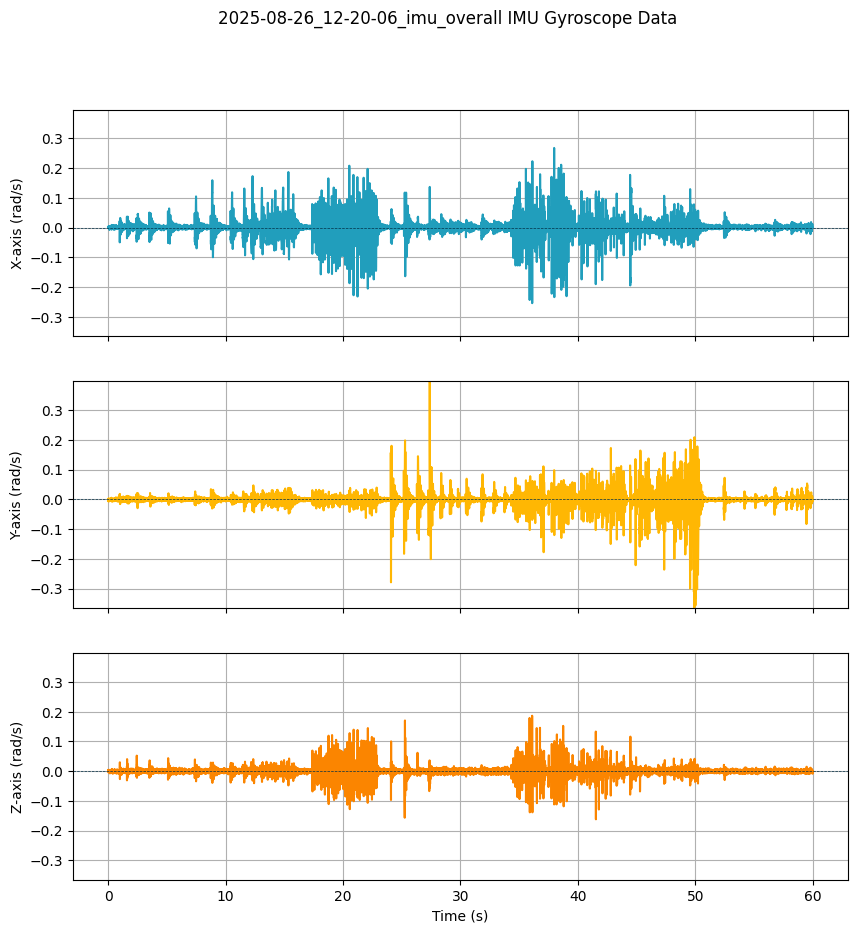

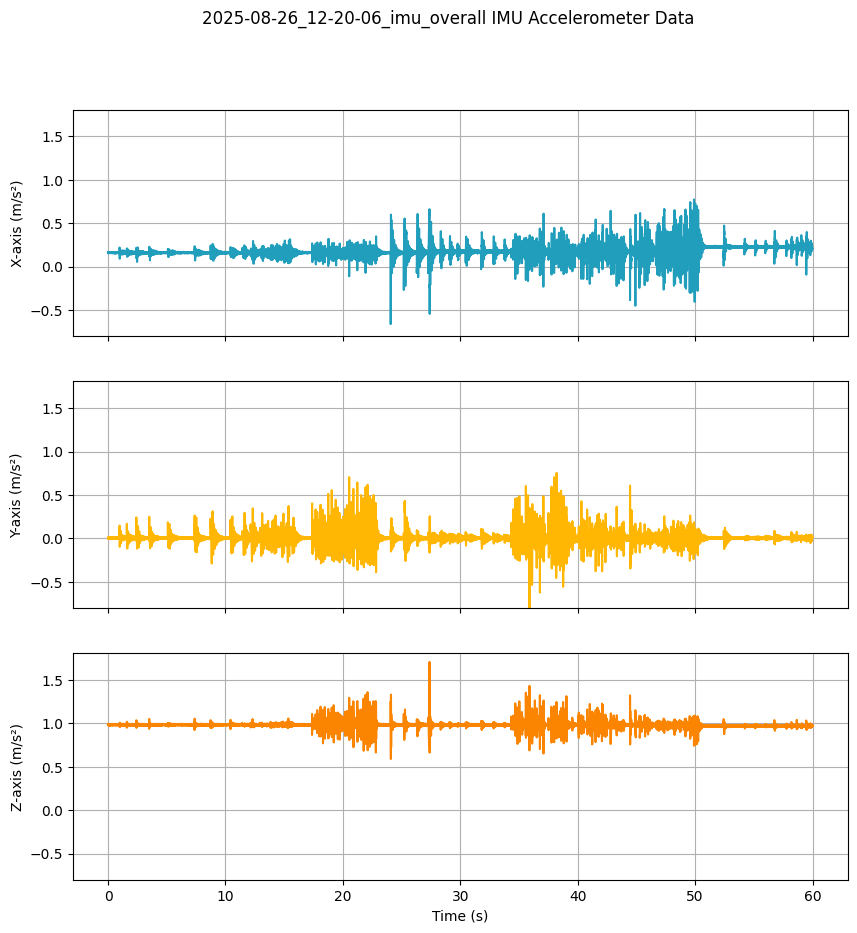

In [2]:
imu_folder = 'IMU_Data'

for filename in os.listdir(imu_folder):
    if filename.endswith('.csv'):
        csv_path = os.path.join(imu_folder, filename)
        plot_imu_data(csv_path, chunk_duration=60)

In [12]:
import pandas as pd
import os
import plotly.graph_objects as go

def plot_avg_acc_movement_axes(csv_file, chunk_duration=60):
    """
    Plots the average accelerometer movement per second for each axis.
    """
    file_name = os.path.splitext(os.path.basename(csv_file))[0]
    df = pd.read_csv(csv_file).dropna()

    samples_per_second = len(df) / chunk_duration
    time_axis = list(range(chunk_duration))
    
    avg_movement = {axis: [] for axis in ['x','y','z']}
    
    for i in range(chunk_duration):
        start_idx = int(i * samples_per_second)
        end_idx = int((i + 1) * samples_per_second)
        for axis in ['x','y','z']:
            # standard deviation per second
            spread = df[f'acc_{axis}'][start_idx:end_idx].std()
            avg_movement[axis].append(spread)
    
    # Plot
    fig = go.Figure()
    axis_colors = {'x':'#8ECAE6','y':'#FFB703','z':'#FB8500'}
    for axis in ['x','y','z']:
        fig.add_trace(go.Scatter( x=time_axis, y=avg_movement[axis], mode='lines+markers', line=dict(color=axis_colors[axis]), name=f'Acc {axis.upper()}'))
    
    fig.update_layout(
        title=f"Average Accelerometer Movement per Second (X, Y, Z): {file_name}",
        xaxis_title="Time (s)", yaxis_title="Acceleration Spread (g)", template="plotly_dark", hovermode="x unified", height=500)
    
    fig.show()

In [ ]:
imu_folder = 'IMU_Data'
for filename in os.listdir(imu_folder):
    if filename.endswith('.csv'):
        csv_path = os.path.join(imu_folder, filename)
        plot_avg_acc_movement_axes(csv_path, chunk_duration=60)

In [ ]:
import pandas as pd
import numpy as np
import os
import plotly.graph_objects as go

def analyze_avg_acc_movement(csv_file, chunk_duration=60):
    """Plots the average accelerometer movement per second,
    and prints the 5 frames with highest, lowest, and closest-to-average movement."""
    file_name = os.path.splitext(os.path.basename(csv_file))[0]
    df = pd.read_csv(csv_file).dropna()

    #Compute the magnitude of acceleration vector of each sample
    acc_magnitude = np.sqrt(df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2)

    #Compute per-second average
    samples_per_second = len(df) / chunk_duration
    avg_movement_per_sec = []
    time_axis = []

    for i in range(chunk_duration):
        start_idx = int(i * samples_per_second)
        end_idx = int((i + 1) * samples_per_second)
        avg_movement = acc_magnitude[start_idx:end_idx].std() 
        avg_movement_per_sec.append(avg_movement)
        time_axis.append(i)

    # Convert to DataFrame for easy ranking
    stats_df = pd.DataFrame({
        "second": time_axis,
        "avg_movement": avg_movement_per_sec
    })

    overall_avg = stats_df["avg_movement"].mean()

    # Highest 5
    highest = stats_df.nlargest(5, "avg_movement")
    # Lowest 5
    lowest = stats_df.nsmallest(5, "avg_movement")
    # Closest to overall average (absolute difference)
    closest = stats_df.iloc[(stats_df["avg_movement"] - overall_avg).abs().argsort()[:5]]

    print(f"\nOverall average movement across all frames: {overall_avg:.6f}\n")
    print("Top 5 highest-movement frames:")
    print(highest.to_string(index=False))
    print("\nTop 5 lowest-movement frames:")
    print(lowest.to_string(index=False))
    print("\nTop 5 frames closest to overall average:")
    print(closest.to_string(index=False))

    #Plot
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=stats_df["second"], y=stats_df["avg_movement"], mode='lines+markers', line=dict(color="#219EBC"),
        error_y=dict(type='constant', value=0.003, color='rgba(0,0,0,0.6)', thickness=1.2, width=2, ), name='Avg Measured Movement (xyz)'))

    fig.add_trace(go.Scatter(
        x=[None], y=[None], mode='lines', line=dict(color='rgba(0,0,0,0.6)', width=2),
        error_y=dict(type='constant', value=0.003, color='rgba(0,0,0,0.6)', thickness=1.5, width=2,), name="±0.003 g Accelerometer Noise (1σ)", showlegend=True))

    def add_markers(subset, color, name):
        fig.add_trace(go.Scatter( x=subset["second"], y=subset["avg_movement"], mode="markers", marker=dict(size=12, color=color, symbol="star"), name=name))

    add_markers(highest, "#023047", "Top 5 Highest")
    add_markers(lowest, '#FFB703', "Top 5 Lowest")
    add_markers(closest, "#Fb8500", "Closest to Average")

    fig.update_layout(
        title=f"Averaged Accelerometer Movement per Second: {file_name}",
        xaxis_title="Time (s)",
        yaxis_title="Acceleration Spread (g)",
        template="plotly_white",
        hovermode="x unified",
        height=400,
        legend=dict(x=0.25, y=0.95, xanchor="right", yanchor="top",
            bgcolor="rgba(0,0,0,0.05)", bordercolor="rgba(255,255,255,0.5)",
            borderwidth=1, font=dict(size=16, color="black")), 
        font=dict(family="Arial, sans-serif", size=16,color="black"),
        title_font=dict(size=18, color="black")
    )
    fig.show()

In [ ]:
imu_folder = "IMU_Data"

for filename in os.listdir(imu_folder):
    if filename.endswith(".csv"):
        csv_path = os.path.join(imu_folder, filename)
        print(f"\nProcessing {filename}")
        analyze_avg_acc_movement(csv_path, chunk_duration=60)



Processing 2025-08-26_12-20-06_imu_overall.csv

Overall average movement across all frames: 0.028434

Top 5 highest-movement frames:
 second  avg_movement
     22      0.094360
     21      0.083524
     35      0.082838
     27      0.081741
     38      0.079131

Top 5 lowest-movement frames:
 second  avg_movement
      6      0.004626
      4      0.004828
      0      0.005300
     23      0.005676
     51      0.005905

Top 5 frames closest to overall average:
 second  avg_movement
     48      0.027989
     47      0.027307
     43      0.027009
     45      0.030990
     17      0.034676
